In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:7


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 20

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 1500)
GT S-parameters shape:  (3, 2, 1500)
Y S-parameters shape:  (3, 2, 62)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1500,)
Y frequencies shape:  (62,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  100000000.0
Mean frequency spacing:  100000000.0
STD frequency spacing:  4.416102007326934e-06
Mode frequency spacing:  100000000.0
Number of samples with non-equal spacing:  126


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1500
N_SPARAMS:  3


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 1500])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 1500])


## Plot some stuff

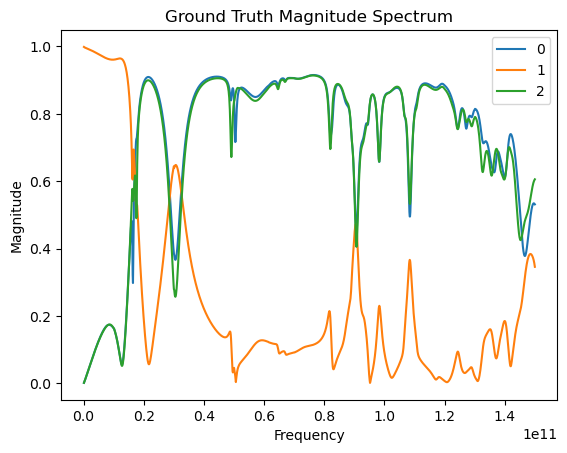

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

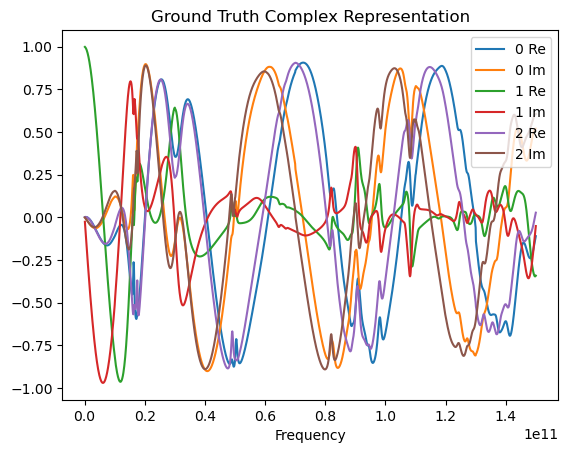

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 2

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)

Number of Ground Truth Frequency Points:  1500
Number of Measurements:  2
Undersampling Ratio:  0.0013333333333333333
[   0 1499]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 2])
y_freqs shape:  (2,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  7
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 1500])


/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  26002


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
#grab the correct file we want for VF
NUM_ACTIVE = 60

LR = 2e-4
NUM_ITER = 2000
TOTAL_ITERS = NUM_ITER * (NUM_ACTIVE + 1)
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

START_LR = LR
END_LR = 1e-5
LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)


train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1], pickRandom=True)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)


    for i in range(int(NUM_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        is_initial_fit = False


    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        var_output = torch.var(outputs, dim=0)

        # Sum to go to [1000]
        var_output = torch.sum(var_output, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(var_output) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(var_output, len(var_output))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  0.1779477596282959
NOISE LEVEL:  0.9999433806580258

ITER  999
TIME:  27.797736644744873
NOISE LEVEL:  0.9449521904263442

ITER  1999
TIME:  54.96999216079712
NOISE LEVEL:  0.8929346421915446

NUM_SAMPLES  0
TIME:  54.96999216079712
picked:  540
[   0  540 1499]
ITER  0
TIME:  55.12061882019043
NOISE LEVEL:  0.8928840848196777

ITER  999
TIME:  81.62952852249146
NOISE LEVEL:  0.8437805460464642

ITER  1999
TIME:  108.04277658462524
NOISE LEVEL:  0.7973322752257439

NUM_SAMPLES  1
TIME:  108.04277658462524
picked:  803
[   0  540  803 1499]
ITER  0
TIME:  108.07027006149292
NOISE LEVEL:  0.7972871307969859

ITER  999
TIME:  135.935809135437
NOISE LEVEL:  0.7534408799721873

ITER  1999
TIME:  163.8977768421173
NOISE LEVEL:  0.7119656098864687

NUM_SAMPLES  2
TIME:  163.8977768421173
picked:  118
[   0  118  540  803 1499]
ITER  0
TIME:  163.92915797233582
NOISE LEVEL:  0.7119252988621287

ITER  999
TIME:  191.51569175720215
NOISE LEVEL:  0.6727734625704479

ITER  1999
TIME

In [23]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([5, 6, 1500])
torch.Size([6, 1500])
torch.Size([6, 1500])


## Plot metrics and outputs

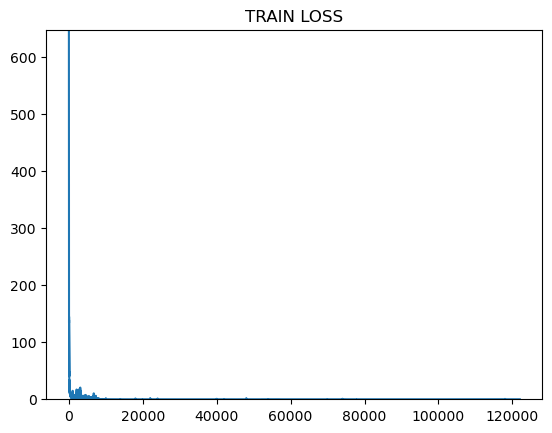

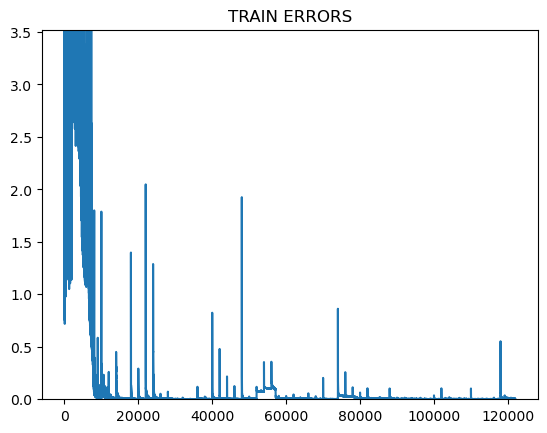

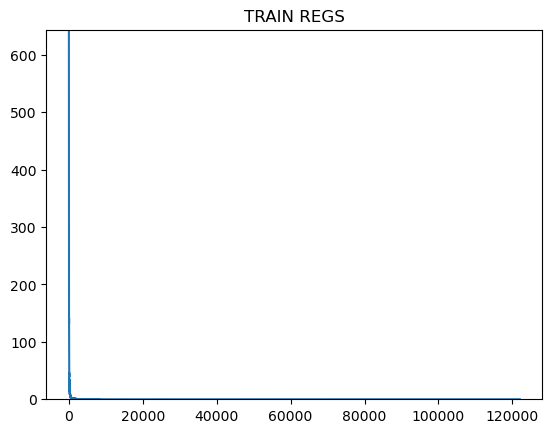

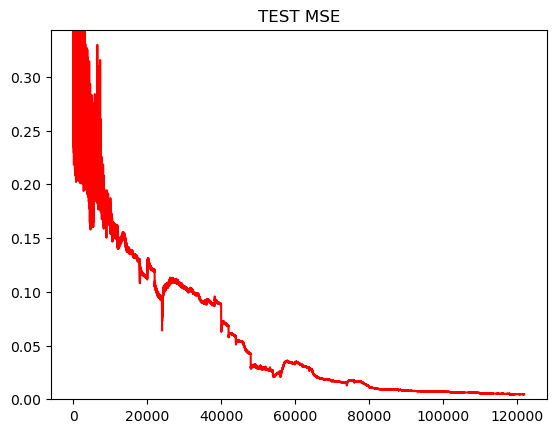

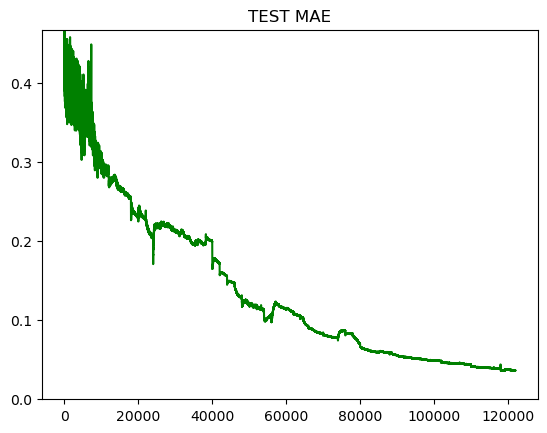

In [24]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [25]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.004553863778710365
Best Test MSE:  0.004450990818440914
Best Test MSE Iteration:  119090


In [26]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case20/case20.s2p
[1.000e+08 6.200e+09 1.110e+10 1.190e+10 1.280e+10 1.530e+10 1.550e+10
 1.660e+10 2.320e+10 2.510e+10 3.260e+10 3.620e+10 3.740e+10 3.750e+10
 4.670e+10 4.960e+10 5.410e+10 5.560e+10 5.660e+10 5.680e+10 5.830e+10
 6.360e+10 6.590e+10 6.910e+10 7.160e+10 7.380e+10 7.540e+10 7.650e+10
 8.040e+10 8.050e+10 8.130e+10 8.530e+10 8.580e+10 8.920e+10 8.930e+10
 9.010e+10 9.610e+10 9.640e+10 9.940e+10 1.000e+11 1.002e+11 1.003e+11
 1.007e+11 1.030e+11 1.074e+11 1.085e+11 1.168e+11 1.179e+11 1.195e+11
 1.245e+11 1.256e+11 1.258e+11 1.284e+11 1.299e+11 1.332e+11 1.394e+11
 1.437e+11 1.439e+11 1.451e+11 1.452e+11 1.477e+11 1.500e+11]
Performing fit with 1 poles.
  Fitting took 0.04131397418677807 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.02785380184650421 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit wi

/u/bodeng/CurveFitting-DIP/random_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.06059574708342552 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.25048567904011193 vs 0.5908603496070803)
Performing fit with 5 poles.
  Fitting took 0.41098834574222565 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 6 poles better than 5 (err 0.13390510135583591 vs 0.25048567904011193)
Performing fit with 6 poles.
  Fitting took 0.08386398665606976 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 was not subtantially better than 6 (err 0.1408918779153767 vs 0.13390510135583591)
Performing fit with 7 poles.
  Fitting took 0.07664456032216549 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 poles better than 6 (err 0.11067875395781156 vs 0.13390510135583591)
Performing fit with 8 poles.
  Fitting took 0.10105288028717041 seconds.
  Filling sampled n

/u/bodeng/CurveFitting-DIP/random_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.428604856133461 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 22 poles better than 19 (err 0.00031738144384999115 vs 0.0007716421634354891)
Performing fit with 22 poles.
  Fitting took 0.24774198792874813 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 23 was not subtantially better than 22 (err 0.00040499458454056856 vs 0.00031738144384999115)
Performing fit with 23 poles.
  Fitting took 0.5372142847627401 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 24 was not subtantially better than 22 (err 0.00018484496166788647 vs 0.00031738144384999115)
Performing fit with 24 poles.
  Fitting took 5.7629185020923615 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 25 was not subtantially better than 22 (err 0.00016495174388907158 vs 0.00031738144384999115)
Fit completed in 11.8249363899

In [27]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([1500, 2, 2, 2])
torch.Size([1500, 2, 2, 2])
torch.Size([62, 2, 2, 2])
(1500, 2, 2, 2)
(1500, 2, 2, 2)
(3, 2, 1500)
(3, 2, 1500)
float32
float32
DIP PSNR:       29.436799567783403
VF PSNR:        40.6473858961641
Final DIP MSE:  0.004553863778710365
VF MSE:         0.0003446048649493605
Mean DIP MSE:  0.004537259694188833


(1500,)
torch.Size([6, 1500])
torch.Size([1, 6, 1500])
torch.Size([1, 6, 62])
torch.Size([1, 6, 1500])
torch.Size([1, 6, 1500])


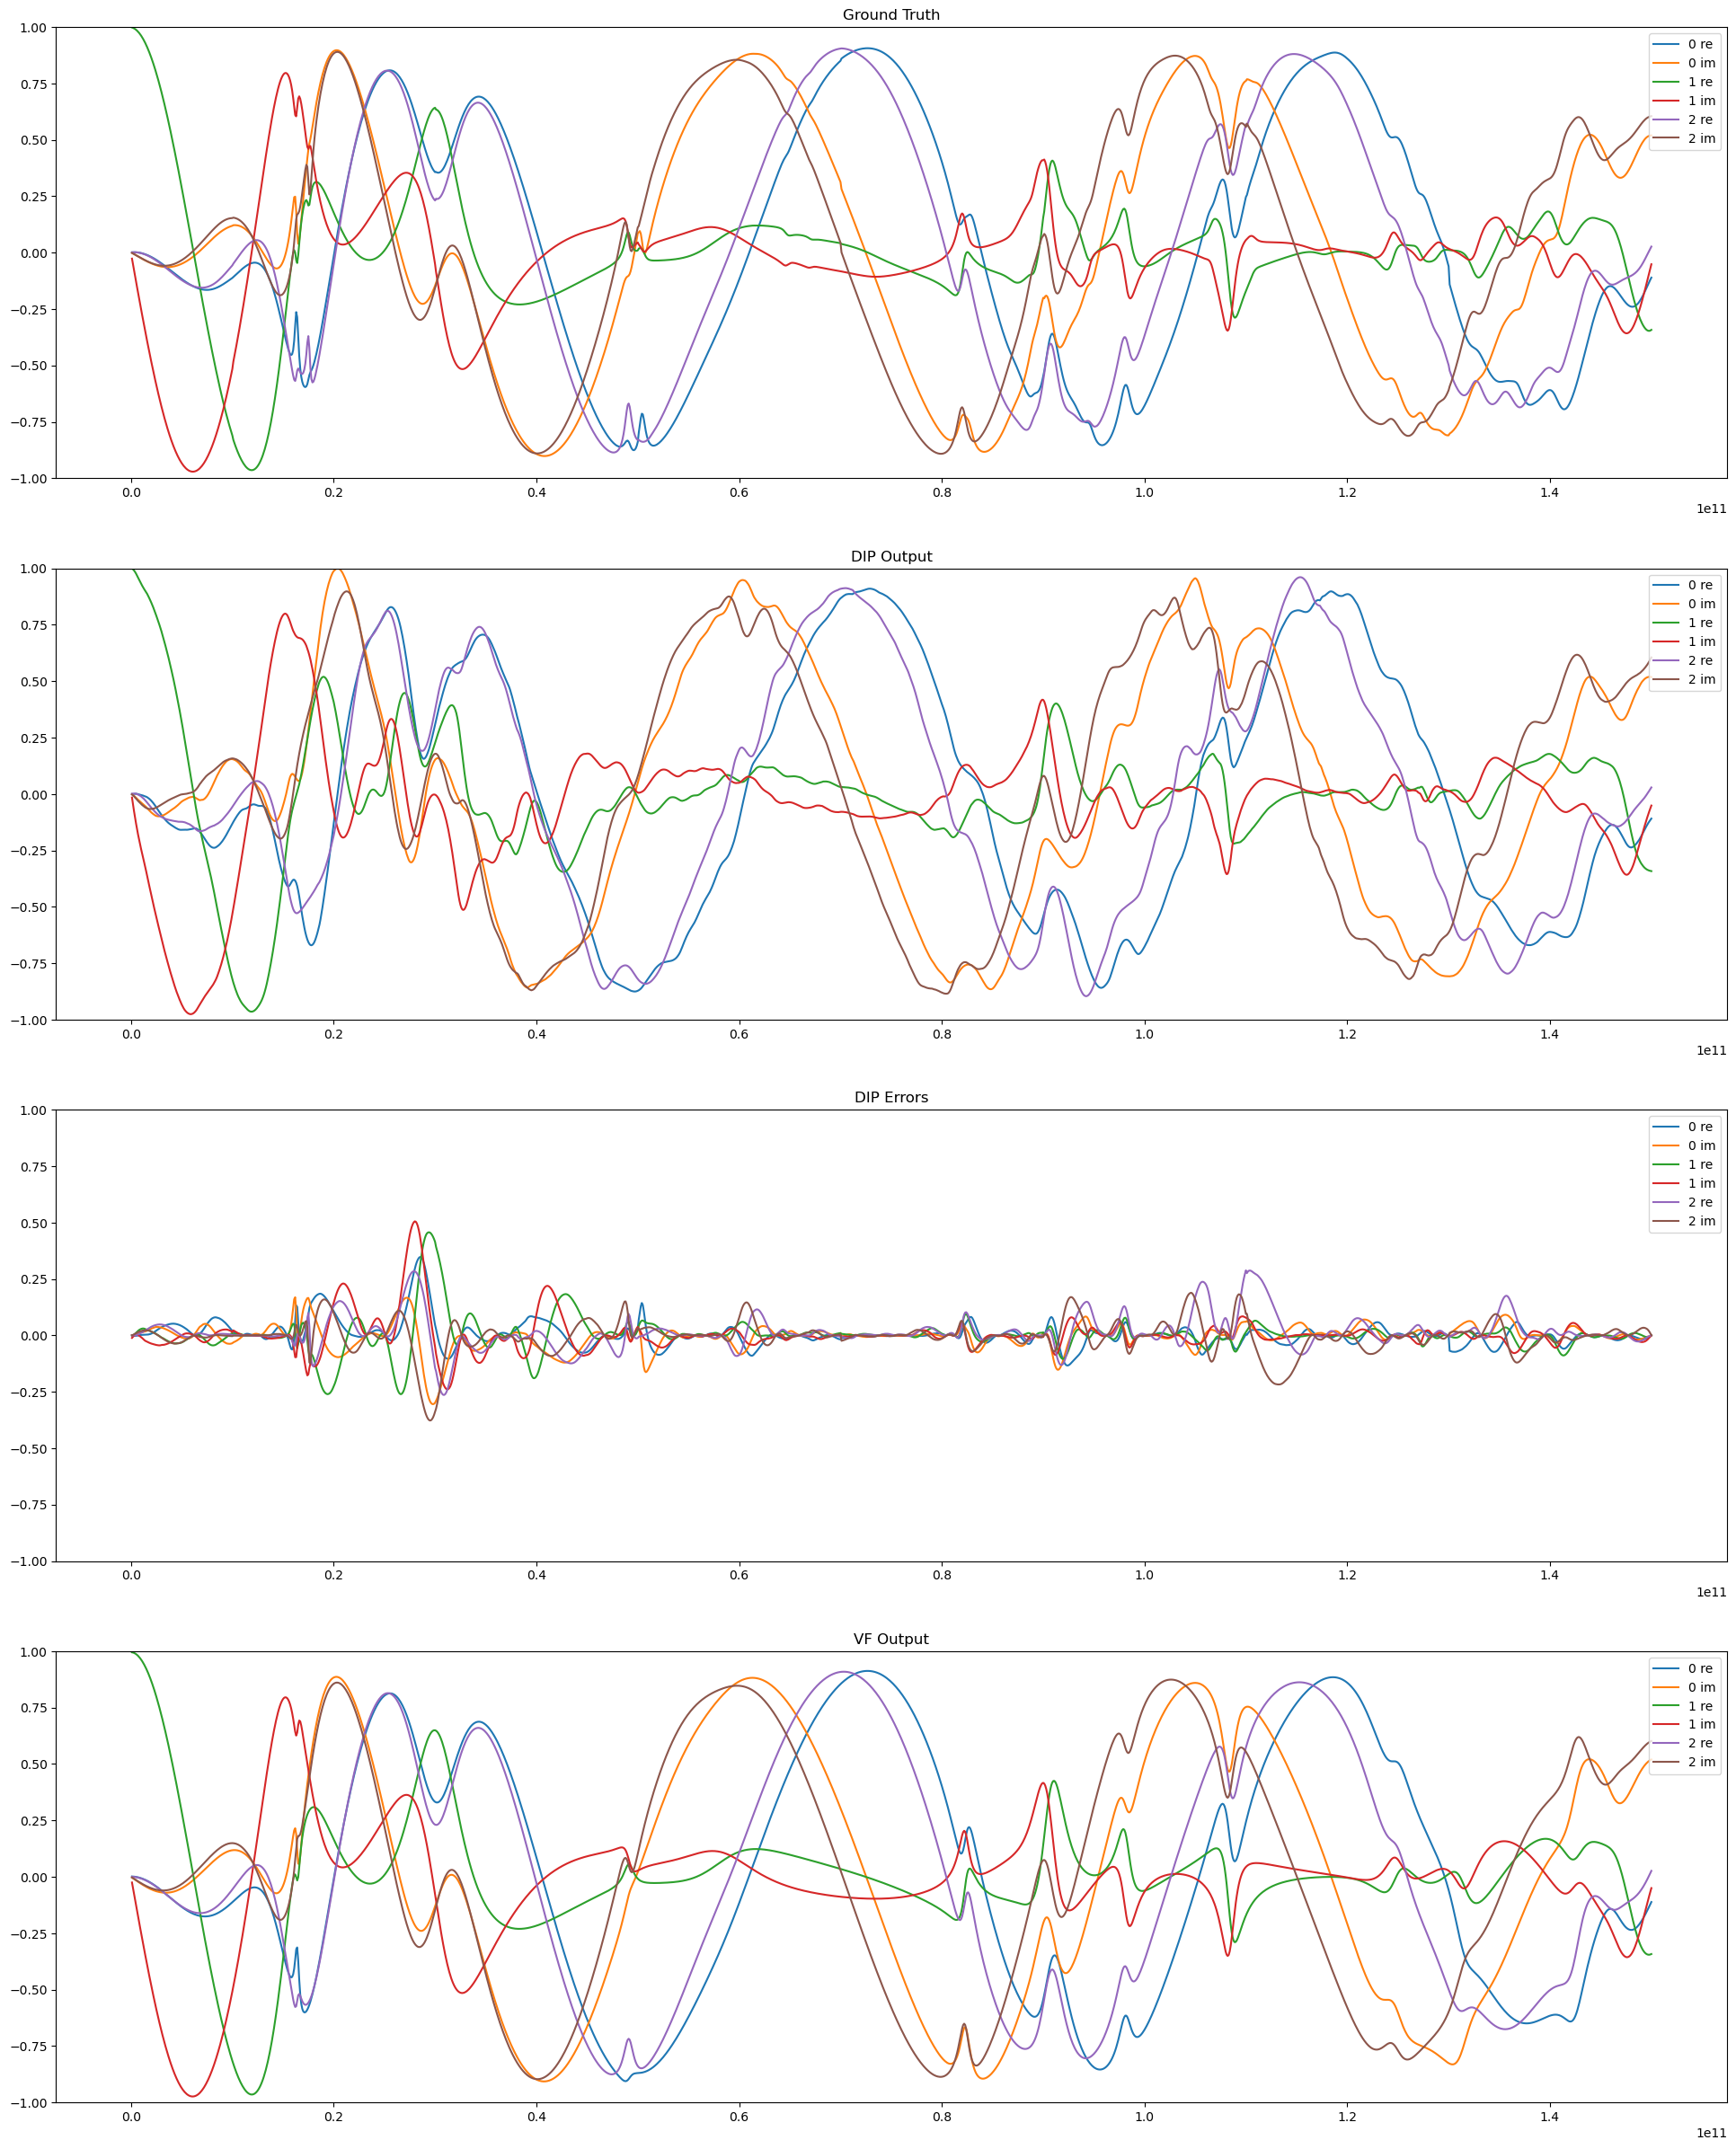

In [28]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [29]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[1.4896e-03, 1.4926e-03, 1.5035e-03, 1.5469e-03, 1.6244e-03, 1.7166e-03,
         1.8403e-03, 1.9288e-03, 1.9694e-03, 1.9691e-03, 1.9289e-03, 1.8260e-03,
         1.6708e-03, 1.4919e-03, 1.1168e-03, 7.4577e-04, 4.8859e-04, 4.5251e-04,
         6.3802e-04, 8.3260e-04, 1.0039e-03, 1.2189e-03, 1.4694e-03, 1.6590e-03,
         1.7901e-03, 1.8527e-03, 1.8476e-03, 1.7377e-03, 1.5218e-03, 1.3216e-03,
         1.1482e-03, 1.0737e-03, 1.0921e-03, 1.1388e-03, 1.2125e-03, 1.2564e-03,
         1.2679e-03, 1.2233e-03, 1.1436e-03, 1.1849e-03, 1.4273e-03, 1.5704e-03,
         1.5587e-03, 1.5907e-03, 1.6477e-03, 1.6827e-03, 1.7335e-03, 1.7342e-03,
         1.6658e-03, 1.4189e-03, 1.3738e-03, 1.3260e-03, 1.3779e-03, 1.5828e-03,
         1.6140e-03, 1.6893e-03, 1.8258e-03, 2.0124e-03, 2.2489e-03, 1.8681e-03,
         1.8051e-03, 1.5153e-03, 1.3528e-03, 1.3173e-03, 1.3745e-03, 8.7068e-04,
         1.1332e-03, 1.2476e-03, 1.4398e-03, 1.4741e-03, 1.4853e-03, 1.5254e-03,
         1.5956e-03, 1.6164e

In [30]:
print(dip_errors[-1])

tensor([[-5.6657e-04, -6.4772e-04, -1.1988e-03, -1.4871e-03, -1.5494e-03,
         -1.1217e-03, -2.0276e-04,  7.0261e-04,  1.6040e-03,  2.1528e-03,
          2.3564e-03,  2.6828e-03,  3.1368e-03,  3.1650e-03,  3.0099e-03,
          3.5101e-03,  3.9777e-03,  4.8422e-03,  6.1058e-03,  7.8599e-03,
          1.0107e-02,  1.2484e-02,  1.4995e-02,  1.7966e-02,  2.1402e-02,
          2.4671e-02,  2.7779e-02,  3.0646e-02,  3.3277e-02,  3.5905e-02,
          3.8536e-02,  4.0932e-02,  4.3100e-02,  4.4877e-02,  4.6272e-02,
          4.7659e-02,  4.9044e-02,  5.0172e-02,  5.1049e-02,  5.1681e-02,
          5.2073e-02,  5.2102e-02,  5.1777e-02,  5.1130e-02,  5.0171e-02,
          4.8976e-02,  4.7551e-02,  4.5852e-02,  4.3883e-02,  4.1625e-02,
          3.9115e-02,  3.6377e-02,  3.3415e-02,  3.0397e-02,  2.7208e-02,
          2.3541e-02,  1.9407e-02,  1.5349e-02,  1.1375e-02,  7.6200e-03,
          4.1693e-03,  1.1458e-03, -1.1922e-03, -2.2982e-03, -2.1659e-03,
         -5.7571e-04,  2.5606e-03,  7.

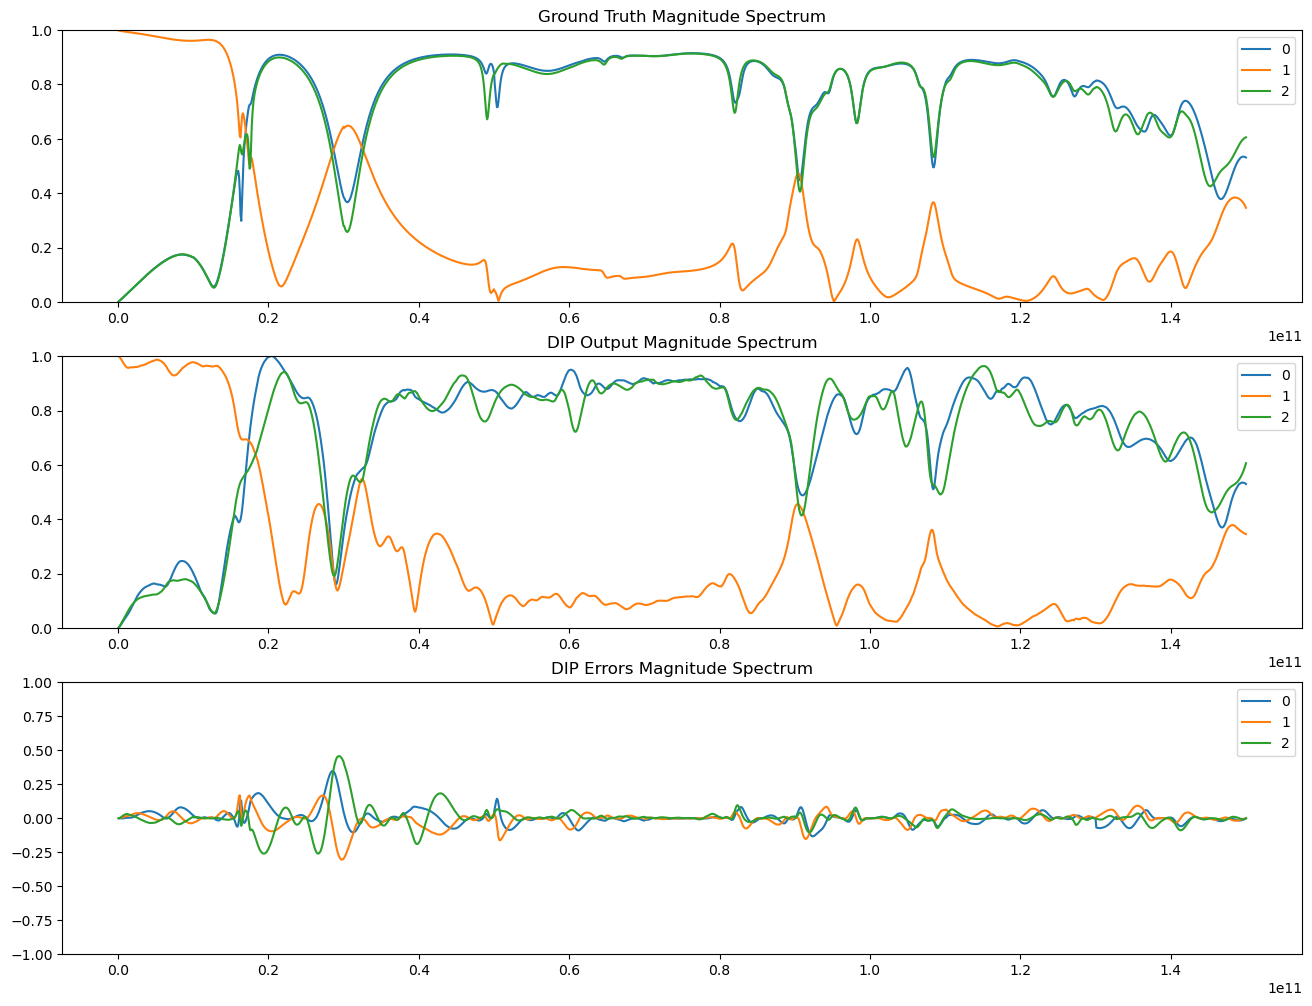

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
print(kept_inds)

[   0   61  110  118  127  152  154  165  231  250  325  361  373  374
  466  495  540  555  565  567  582  635  658  690  715  737  753  764
  803  804  812  852  857  891  892  900  960  963  993  999 1001 1002
 1006 1029 1073 1084 1167 1178 1194 1244 1255 1257 1283 1298 1331 1393
 1436 1438 1450 1451 1476 1499]
